## We start by importing all of the libaries and functions we'll need 

In [2]:
# System tools
import os

# Data analysis
import pandas as pd
from collections import Counter
from itertools import combinations 
from tqdm import tqdm

# NLP
import spacy
nlp = spacy.load("en_core_web_sm")

# Network analysis tools
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

## Define input file and read data to dataframe

In [3]:
input_file = os.path.join("..", "data", "tabular_data", "fake_or_real_news.csv")

In [4]:
data = pd.read_csv(input_file)

In [7]:
data

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


## Extract all named individuals

We use ```spaCy``` to extract only mentions of PERSONS or LOC in the texts.

NB: See final comment below under ```Problems```!

In [9]:
real_text = data[data["label"] == "REAL"]["text"]

In [14]:
# get list of lists of entities
person_list = []

# iterate over every text
for doc in tqdm(nlp.pipe(real_text, batch_size=500)):
    # temp list
    tmp_list = []
    # get named entities for each text
    for entity in doc.ents:
        # if it is a PERSON
        if entity.label_ == "PERSON":
            # append to temporary list
            tmp_list.append(entity.text)
    # add to output list
    person_list.append(tmp_list)

3171it [06:18,  8.39it/s]


## Create edgelist using ```itertools.combinations()```

In [16]:
test = ["A", "B", "C", "D"]

In [33]:
edgelist2 = []
for sublist in person_list:
    edgelist2.extend(list(combinations(sublist, 2)))

In [29]:
# create output edgelist
edgelist = []

# go over each list or "document" one at a time
for sublist in person_list:
    # get pairings in this doc
    edges = list(combinations(sublist, 2))
    # for every possible edge
    for edge in edges:
        # if the two values are the same
        if edge[0]==edge[1]:
            # do nothing
            pass
        # otherwise append to output
        else:
            edgelist.append(edge)

## Count occurrences using ```Counter()```

Create DF from Counter object, showing each node pair and the edge weight.

In [38]:
# create a weighted edgelist
weighted_edges = []

# use counter on edgelist
for key, value in Counter(edgelist).items():
    nodeA = key[0]
    nodeB = key[1]
    weight = value
    # append to output
    weighted_edges.append((nodeA, nodeB, weight))

In [42]:
edges_df = pd.DataFrame(weighted_edges, columns=["nodeA", "nodeB", "weight"])

In [46]:
edges_df

,nodeA,nodeB,weight
0,John F. Kerry,Kerry,19
1,John F. Kerry,Laurent Fabius,2
2,John F. Kerry,Francois Hollande,1
3,John F. Kerry,Obama,26
4,John F. Kerry,Benjamin Netanyahu,3
...,...,...,...
303605,Carly Fiorina,Fergus Cullen,1
303606,Carly Fiorina,Jeb Bush's,1
303607,Fergus Cullen,Donald Trump,1
303608,Fergus Cullen,Jeb Bush's,1


__Filter based on edgeweight__

In [52]:
filtered = edges_df[edges_df["weight"]>100]

## Create network

Create a graph object called ```G```

In [53]:
G = nx.from_pandas_edgelist(filtered, "nodeA", "nodeB", ["weight"])

We're just going to use the simplest plotting algorithm. But feel free to experiment with different approaches and see how they perform differently:

https://networkx.org/documentation/stable/reference/drawing.html

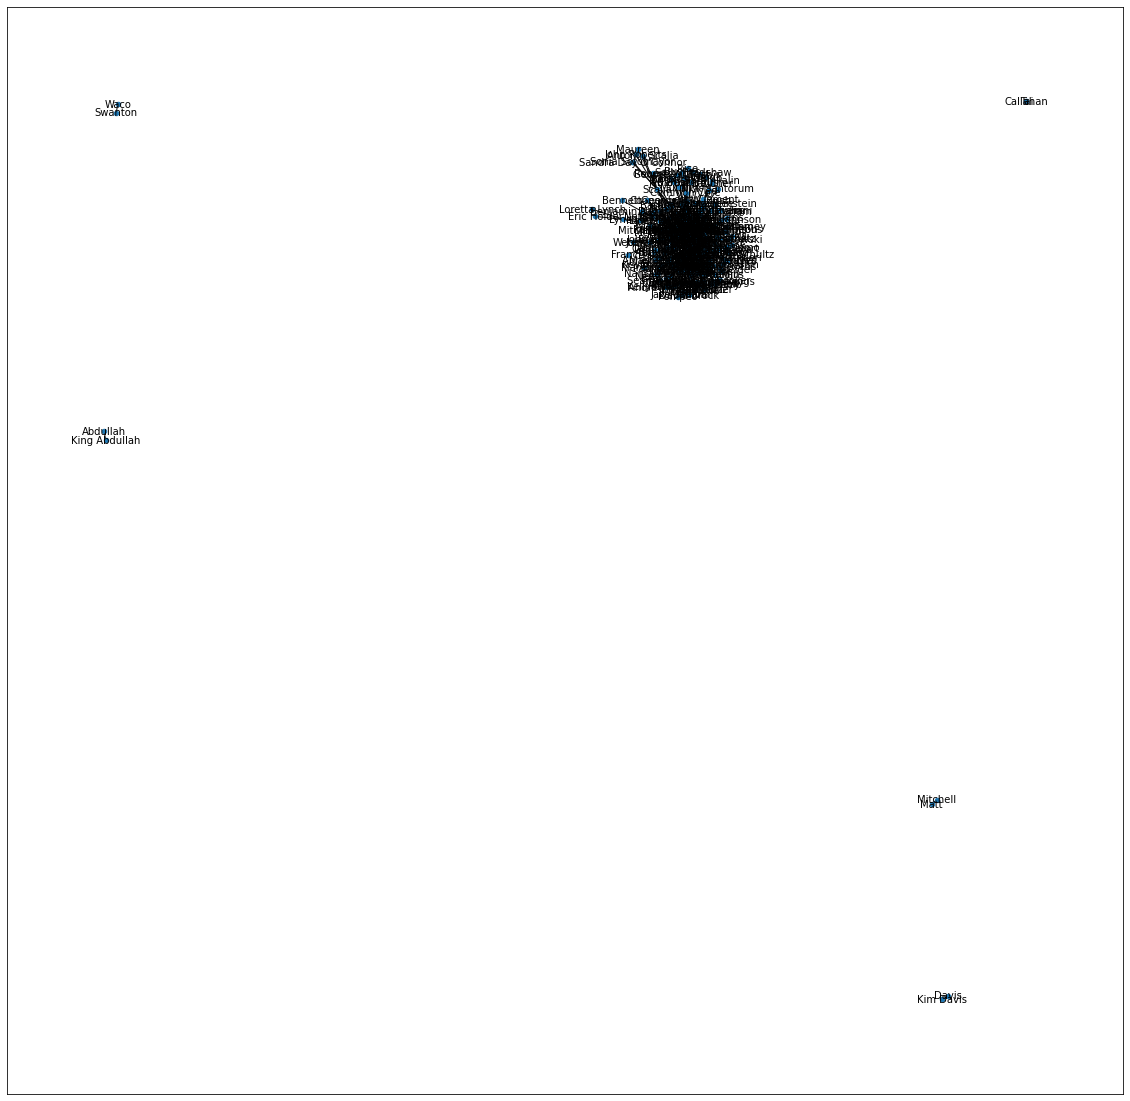

In [54]:
nx.draw_networkx(G, with_labels=True, node_size=20, font_size=10)

Make sure the folder ```../viz``` exists already for saving the image

## Centrality measures

In [55]:
ev = nx.eigenvector_centrality(G)

In [57]:
eigenvector_df = pd.DataFrame(ev.items())

In [60]:
eigenvector_df.sort_values(1, ascending=False)

,0,1
7,Clinton,4.457001e-01
3,Donald Trump,2.434021e-01
2,Hillary Clinton,2.389143e-01
1,Obama,2.323083e-01
12,Bush,2.301316e-01
...,...,...
100,Mitchell,1.320051e-25
229,Swanton,1.320051e-25
230,Waco,1.320051e-25
101,Matt,1.320051e-25


## Problems

- How much of an issue is coreference in the data?

- We've said that we're basing this on document co-occurence. But then why are there some node pairs with a greater edge weight than the number of documents?

- We could resolve this by changing the final line of our ```spaCy``` pipeline to be something like ```post_entities.append(set(sorted(tmp_entities)))```. 
    - What does this code do?